<a href="https://colab.research.google.com/github/PriyankaTUI/AudioClassificationWithDeepLearningAnalysis/blob/master/LwF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/PriyankaTUI/AudioClassificationWithDeepLearningAnalysis.git
%cd AudioClassificationWithDeepLearningAnalysis
!pwd

Cloning into 'AudioClassificationWithDeepLearningAnalysis'...
remote: Enumerating objects: 437, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 437 (delta 32), reused 23 (delta 19), pack-reused 399
Receiving objects: 100% (437/437), 47.49 MiB | 17.28 MiB/s, done.
Resolving deltas: 100% (199/199), done.
/content/AudioClassificationWithDeepLearningAnalysis
/content/AudioClassificationWithDeepLearningAnalysis


# **Learning without Forgetting:(Lwf)**

In [2]:
import torch
import models
import copy
import os.path
import torch.nn.functional as F
from torch.utils.data import DataLoader
from utils import label_to_index, index_to_label, get_average_of_list
from dataset import SubsetSC
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statistics import mean
import torch.nn as nn
import numpy as np

In [3]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 10]

**DATA PROCESSING**

For Learning without Forgetting, we will use novel data classes to further adapt our classification network. Additionally, we would use old data to evaluate the network's performance for old classes.

To train a network and assess its accuracy while it is being trained, we have developed novel_train_dataloader and novel_test_dataloader. In order to determine whether the network is still effective for old classes and has less of an impact from catastrophic forgetting, old_test_dataloder will be utilized to calculate the accuracy of old classes.

In [4]:
#list of novel class targets that we'd use for further training 
random_targets = ['follow']

traindata = SubsetSC("training", "novel", novel_class_list= random_targets)
testdata = SubsetSC("testing", "novel", novel_class_list= random_targets)

#for classification labels would be combination of novel classes and old classes(digits)
targets_list = [os.path.basename(os.path.dirname(traindata._walker[i])) for i in range(len(traindata))]
novel_targets = list(set(targets_list))
digits = ['zero','one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'] 
total_targets_list = digits + novel_targets 

#create index list of total target to later use in training data analysis
novel_targets_list_indices = []
for i in novel_targets:
        novel_targets_list_indices.append(label_to_index(total_targets_list, i).item())

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
        tensors, targets = [], []
        for waveform, label in batch:
                tensors += [torch.squeeze(waveform)]
                targets += [label_to_index(total_targets_list, label)]
                
        tensors = torch.unsqueeze(pad_sequence(tensors), 1)
        targets = torch.stack(targets)
        return tensors, targets

novel_train_dataloader = DataLoader(traindata,batch_size=20, collate_fn=collate_fn, shuffle=True)
novel_test_dataloader = DataLoader(testdata, batch_size = 20, collate_fn=collate_fn, shuffle=True)

old_testdata = SubsetSC("testing", "old")
old_test_dataloader = DataLoader(old_testdata,batch_size=20, collate_fn=collate_fn, shuffle=True)

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

PRE-TRAINED MODEL

In [5]:
def get_convnet(convnet_type):
    name = convnet_type.lower()
    if name == "vgg":
      FILE_PATH = "./savedmodels/vgg_checkpoint.pth"
      print("getting VGG pre-trained model")
      vgg_model = models.VGGNet()
      vgg_model.load_state_dict(copy.deepcopy(torch.load(FILE_PATH, map_location='cpu')), strict=False)
      return vgg_model
    elif name == "alexnet":
      FILE_PATH = "./savedmodels/checkpoint_alexnet.pth"
      print("getting AlexNet pre-trained model")
      alexnet_model = models.AlexNet()
      alexnet_model.load_state_dict(copy.deepcopy(torch.load(FILE_PATH, map_location='cpu')), strict=False)
      return alexnet_model

# **TRAINING**

**# Learning without Forgetting algorithm:**

<ins>Start with:

$   \theta_s $: shared parameters

$   \theta_o $: task specific parameters for each old task

$   X_n, Y_n $: training  data and ground truth on the new task



<ins>Initialization:

$ Y_o \gets CNN(X_n, \theta_s, \theta_o)$    //compute output of old tasks for new data

$ \theta_n \gets RANDINIT(|\theta_n|)$    //randomly initialize new parameters



<ins>Train:


Define $\hat{Y}_o \equiv CNN(X_n, \hat{\theta}_s, \hat{\theta}_o)$    // old task output

Define $\hat{Y}_n \equiv CNN(X_n, \hat{\theta}_s, \hat{\theta}_n)$    // new task output

$\theta_s^*, \theta_o^*, \theta_n^* \gets \underset{\hat{\theta}_s, \hat{\theta}_o, \hat{\theta}_n}{\arg\min} (\lambda_o \mathcal{L_{old}}(Y_o, \hat{Y}_o) + \mathcal{L_{new}}(Y_n, \hat{Y}_n) + \mathcal{R}(\hat{\theta}_s, \hat{\theta}_o, \hat{\theta}_n))$


<ins>Where:

$\mathcal{L_{old}}(Y_o, \hat{Y}_o)$ is modified cross entropy loss also known as Knowledge Distillation loss


$$
\mathcal{L_{old}}(y_o, \hat{y}_o) = -{H}({y}_o^{'}, \hat{y}_o^{'} )
                                        = - \sum_{i=1}^{l} y_o^{'(i)} log (\hat{y}_o^{'(i)})
$$


$l$ is number of the labels


$y_o^{'(i)}, \hat{y}_o^{'(i)}$ are the modified version of recorded current probabilities $y_o^{(i)}, \hat{y}_o^{(i)}$

$$
y_o^{'(i)} = \frac{(y_o^{(i)})^{\frac{1}{T}}}{\sum_{j}(y_o^{(j)})^{\frac{1}{T}}}
$$
$$
\hat{y}_o^{'(i)} = \frac{(\hat{y}_o^{(i)})^{\frac{1}{T}}}{\sum_{j}(\hat{y}_o^{(j)})^{\frac{1}{T}}}
$$

$T$ is teprature;  $T > 1$ is recommended; It makes lower logit values more significant and pushes the network to more effectively encode class similarities.

$\mathcal{L_{new}}(y_n, \hat{y}_n)$ is cross entropy loss between new logits and ground truth


$$
\mathcal{L_{new}}(y_n, \hat{y}_n) = - y_n . log( \hat{y}_n)
$$
$y_n$ one hot ground truth label vector

$\hat{y}_n$ softmax output of the network


$\mathcal{R}$ is Regularization term for stochatic gradient descent


In [6]:
def calculate_accuracy(dataloader, model):
  #Accuracy for given test data
  model.to(device)
  with torch.no_grad():
    class_acc =[]
    model.eval()
    for i, (inputs, labels) in enumerate(dataloader):
      inputs, labels = inputs.to(device), labels.to(device)
      logits = model(inputs)
      loss = F.cross_entropy(logits, labels)
      _, pred = logits.max(1)
      acc = (pred == labels).sum().item() / pred.size(0)
      class_acc.append(acc)
  return mean(class_acc), loss.item()

In [11]:
init_labels = {
 'negative' : 'Negative',
 'negative_norm' : 'Negative_with_Normalization',
 'random' : 'Random',
 'random_norm' : 'Random_with_Normalization',
 'xavier_uniform' : 'Xavier_Uniform',
 'xavier_uniform_norm' : 'Xavier_Uniform_with_Normalization',
 'xavier_normal' : 'Xavier_Normal',
 'xavier_normal_norm' : 'Xavier_Normal_with_Normalization',
 'kaiming_uniform' : 'Kaiming_Uniform',
 'kaiming_uniform_norm' : 'Kaiming_Uniform_with_Normalization',
 'kaiming_normal' : 'Kaiming_Normal',
 'kaiming_normal_norm' : 'Kaiming_Normal_with_Normalization'
}

def _normalization(old_weights,  incremental_model_linear_weights):
  # L2 regularization of weights
  old_weights_norm = torch.norm(old_weights, p=2, dim=1)
  incremental_model_linear_weights_norm = torch.norm(incremental_model_linear_weights, p=2, dim=1)
  old_weights_mean = torch.mean(old_weights_norm)
  incremental_model_linear_weights_mean = torch.mean(incremental_model_linear_weights_norm)
  gamma = old_weights_mean+incremental_model_linear_weights_mean
  old_weights = old_weights/gamma
  incremental_model_linear_weights = incremental_model_linear_weights/gamma

  return old_weights, incremental_model_linear_weights
  
def _incremental_model(model, init_method = init_labels['random'], is_normalize = False, _no_out_features:int = 11, _no_novel_class: int = 1):
  in_features = model.linear.in_features
  out_features = model.linear.out_features
  incremental_model_linear = nn.Linear(in_features=in_features, out_features=_no_novel_class)
  incremental_model_linear.to(device)
  model.to(device)
  
  #Initialize weights 
  if init_method == init_labels['negative']:
    print(f'Initialization: {init_method}')
    nn.init.constant_(incremental_model_linear.weight, -1)
  elif init_method == init_labels['xavier_uniform']:
    print(f'Initialization: {init_method}')
    nn.init.xavier_uniform_(incremental_model_linear.weight)
  elif init_method == init_labels['xavier_normal']:
    print(f'Initialization: {init_method}')
    nn.init.xavier_normal_(incremental_model_linear.weight)
  elif init_method == init_labels['kaiming_uniform']:
    print(f'Initialization: {init_method}')
    nn.init.kaiming_uniform_(incremental_model_linear.weight, nonlinearity='linear')
  elif init_method == init_labels['kaiming_normal']:
    print(f'Initialization: {init_method}')
    nn.init.kaiming_normal_(incremental_model_linear.weight)

  nn.init.constant_(incremental_model_linear.bias, 0)

  old_weights = copy.deepcopy(model.linear.weight.data)
  old_bias = copy.deepcopy(model.linear.bias.data)
  incremental_model_linear_weights = copy.deepcopy(incremental_model_linear.weight.data)
  incremental_model_linear_bias = copy.deepcopy(incremental_model_linear.bias.data)
  # model.linear = nn.Linear(in_features=in_features, out_features=len(total_targets_list))
  model.linear = nn.Linear(in_features=in_features, out_features=_no_out_features)

  if is_normalize:
    #if L2 normalization is used
    print('with L2 normalization')
    old_weights, incremental_model_linear_weights = _normalization(old_weights,  incremental_model_linear_weights
                                                                   )
  new_weights = torch.cat([old_weights, incremental_model_linear_weights], dim=0)
  new_bias = torch.cat([old_bias, incremental_model_linear_bias] ,dim=0)
  model.linear.weight.data = new_weights
  model.linear.bias.data = new_bias

  return model

Fllowing code contain function for training LwF algorithm

In [8]:
def _KD_loss(pred, soft, T):
    #pred: predicted output probabilities \hat{Y}_o
    #sof: previously recorded output probabilities 
    #on old pre-trained network Y_o
    #T: temprature

    pred = torch.log_softmax(pred / T, dim=1)
    soft = torch.softmax(soft / T, dim=1)
    return -1 * torch.mul(soft, pred).sum() / pred.shape[0]

def train(train_dataloader, 
          test_dataloader, 
          old_test_dataloader, 
          optimizer,scheduler, 
          model, 
          old_model, 
          num_epochs, 
          alpha=1, 
          T=1, 
          log = [], 
          _novel_class_len:int = 1,
          show_new:bool = True):
  
  #Input parameters    :
  #train_dataloader    : PyTorch dataloader for novel training data
  #test_dataloader     : Pytorch dataloader for novel validation data
  #old_test_dataloader : Dataloader for old tasks to measure the performance of old data
  #optimizer           : SGD optimizer as suggested in LwF original paper
  #scheduler           : scheduler to adjust the learning rate during training
  #model               : Extended network
  #old_model           : copy of old pre-trained network before extension to record Y_o
  #num_epochs.         : number of epochs
  #alpha               : alpha scaling factor, default = 1
  #T                   : temparature of KD loss, defult = 1
  #log                 : list to store losses and accuracies during training
  #_novel_class_len    : #no of of newly added task, mostly: 1 


  for epoch in range(num_epochs):
    running_loss = []
    running_accuracy = []
    model.to(device)
    model.train()
    old_model.to(device)

    for i, (inputs, labels) in enumerate(train_dataloader):
      ##Calculate New loss L_new between logits of novel train data and ground truth
      inputs, labels = inputs.to(device), labels.to(device)
      logits = model(inputs) #batch_size x num of out_features in last layer
      loss_new = F.cross_entropy(logits, labels)

      ##Calculate L_old/ Knowledge Distillation Loss(KLD)
      old_logits = old_model(inputs)
      loss_kd = _KD_loss(logits[:, :-_novel_class_len],old_logits,T)

      ##Total Loss
      total_loss = alpha * loss_kd + loss_new ##regularization term for optimizer added with weight decaying      optimizer.zero_grad()
      total_loss.backward() 
      optimizer.step()
      scheduler.step()
      running_loss.append(total_loss.item())
      _, pred = logits.max(1)
      acc = (pred == labels).sum().item() / pred.size(0)
      running_accuracy.append(acc)
   
    train_loss = mean(running_loss)
    train_accuracy = mean(running_accuracy)
    test_accuracy , test_loss = calculate_accuracy(dataloader=test_dataloader, model=model)
    old_class_accuracy, old_class_loss = calculate_accuracy(dataloader=old_test_dataloader, model=model)
   
    if show_new:
      print(f"Epoch [{epoch}]... train_loss: {train_loss}, train_acc: {train_accuracy}")
      print(f"\t     val_loss: {test_loss}, val_acc: {test_accuracy}")
    print(f"\t     old_loss: {old_class_loss}, old_acc: {old_class_accuracy}")
    
    log.append({
    'epoch': epoch,
    'train_loss': train_loss,
    'train_accuracy': train_accuracy,
    'val_loss': test_loss,
    'val_accuracy': test_accuracy,
    'old_class_loss' : old_class_loss,
    'old_class_accuracy': old_class_accuracy
    })
    
  return

# Lwf for single class increment


The LwF algorithm for single task increment is examined in this section. We compared novel training and validation and old tasks' accuracy with respect to different initialization methods and their corresponding normalization. In this case, we trained the network for each method separately for 50 epochs and saved the results in a separate pickle file. We later used these saved results to plot the response of all initialization methods in a single plot. Then, in a separate plot, plot old task accuracy for all methods and novel validation accuracy with respect to all initialization methods.

In [ ]:
learning_rate = 0.00001
T = 2
alpha = 1
weight_decay = 1e-6
num_epochs = 50
log = []
_network = 'vgg'

# #Model 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load model
print("Loading the pre-trained model...")
model = get_convnet("vgg")

#save old accuracy before increment
old_class_accuracy, old_class_loss = calculate_accuracy(dataloader=old_test_dataloader, model=model)
log.append({
  'epoch': -1,
  'train_loss': np.nan,
  'train_accuracy': 0,
  'val_loss': np.nan,
  'val_accuracy': 0,
  'old_class_loss' : old_class_loss,
  'old_class_accuracy': old_class_accuracy
  })
#save prev model before increment
prev_model = copy.deepcopy(model)
#freeze previous model
for param in prev_model.parameters():
  param.requires_grad = False

# Add weights at the last linear layer for novel class 
# model = _incremental_model(model, init_labels['random'], is_normalize = False)
# model = _incremental_model(model, init_labels['negative'], is_normalize = True)
# model = _incremental_model(model, init_labels['xavier_uniform'], is_normalize = True)
model = _incremental_model(model, init_labels['kaiming_uniform'], is_normalize = True)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,30,50,70,80], gamma=0.1)

Loading the pre-trained model...
getting VGG pre-trained model
Initialization: Kaiming_Uniform
with L2 normalization


In [ ]:
train(novel_train_dataloader, 
      novel_test_dataloader, 
      old_test_dataloader, 
      optimizer,
      scheduler, 
      model, 
      prev_model, 
      num_epochs, 
      alpha, 
      T, 
      log)

Epoch [0]... train_loss: 3.198466017276426, train_acc: 0.9443037974683545
	     val_loss: 1.3401232957839966, val_acc: 0.6888888888888889
	     old_loss: 0.6548370122909546, old_acc: 0.5661581137309293
Epoch [1]... train_loss: 3.0347232320640662, train_acc: 0.9588274483677548
	     val_loss: 0.9004289507865906, val_acc: 0.7037037037037037
	     old_loss: 1.2353719472885132, old_acc: 0.5657073509015257
Epoch [2]... train_loss: 3.0623734525487394, train_acc: 0.9462025316455696
	     val_loss: 0.9500513076782227, val_acc: 0.7
	     old_loss: 0.9397092461585999, old_acc: 0.5670596393897365
Epoch [3]... train_loss: 3.191615278207803, train_acc: 0.9360093271152565
	     val_loss: 0.9656901955604553, val_acc: 0.7
	     old_loss: 1.102896809577942, old_acc: 0.5661581137309293
Epoch [4]... train_loss: 3.1671236889271794, train_acc: 0.9461025982678214
	     val_loss: 0.9978256821632385, val_acc: 0.7037037037037037
	     old_loss: 1.7416846752166748, old_acc: 0.5661581137309293
Epoch [5]... train

In [ ]:
df_log = pd.DataFrame(log)
filename = str(datetime.now().date()) + '_' + str(datetime.now().time()).replace(':', '.')
# path = "results_lwof_" + str(init_labels['random_norm']) + '_' + filename
# path = "results_lwof_" + str(init_labels['random']) + '_' + filename
# path = "results_lwof_" + str(init_labels['negative']) + '_' + filename
# path = "results_lwof_" + str(init_labels['negative_norm']) + '_' + filename
# path = "results_lwof_" + str(init_labels['xavier_uniform']) + '_' + filename
# path = "results_lwof_" + str(init_labels['xavier_uniform_norm']) + '_' + filename
# path = "results_lwof_" + str(init_labels['kaiming_uniform']) + '_' + filename
path = "results_lwof_" + str(init_labels['kaiming_uniform_norm']) + '_' + filename

df_log.to_pickle(path)
print(f"Saved training data to file {path}")

Saved training data to file results_lwof_Kaiming_Uniform_Norm_2022-10-27_09.52.23.893527


Load and plot to compare Accuracy of Novel and Old class using LwF Algorithm w.r.t. Normalization and Initialization

In [ ]:
df_negative = pd.read_pickle("results_lwof_Negative_2022-10-27_09.14.06.832250")  
df_negative_norm = pd.read_pickle("results_lwof_Negative_Norm_2022-10-27_09.22.25.617055")
df_random = pd.read_pickle("results_lwof_Random_2022-10-27_09.05.49.159278")
df_random_norm = pd.read_pickle("results_lwof_Random_Norm_2022-10-27_08.58.20.321314")
df_xavier = pd.read_pickle("results_lwof_Xavier_Uniform_2022-10-27_09.30.35.618492")
df_xavier_norm = pd.read_pickle("results_lwof_Xavier_Uniform_Norm_2022-10-27_09.38.17.821067")
df_kaiming = pd.read_pickle("results_lwof_Kaiming_Uniform_2022-10-27_09.45.45.179086")
df_kaiming_norm = pd.read_pickle("results_lwof_Kaiming_Uniform_Norm_2022-10-27_09.52.23.893527")

In [ ]:
plt.rcParams["figure.figsize"] = [15, 15]

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)

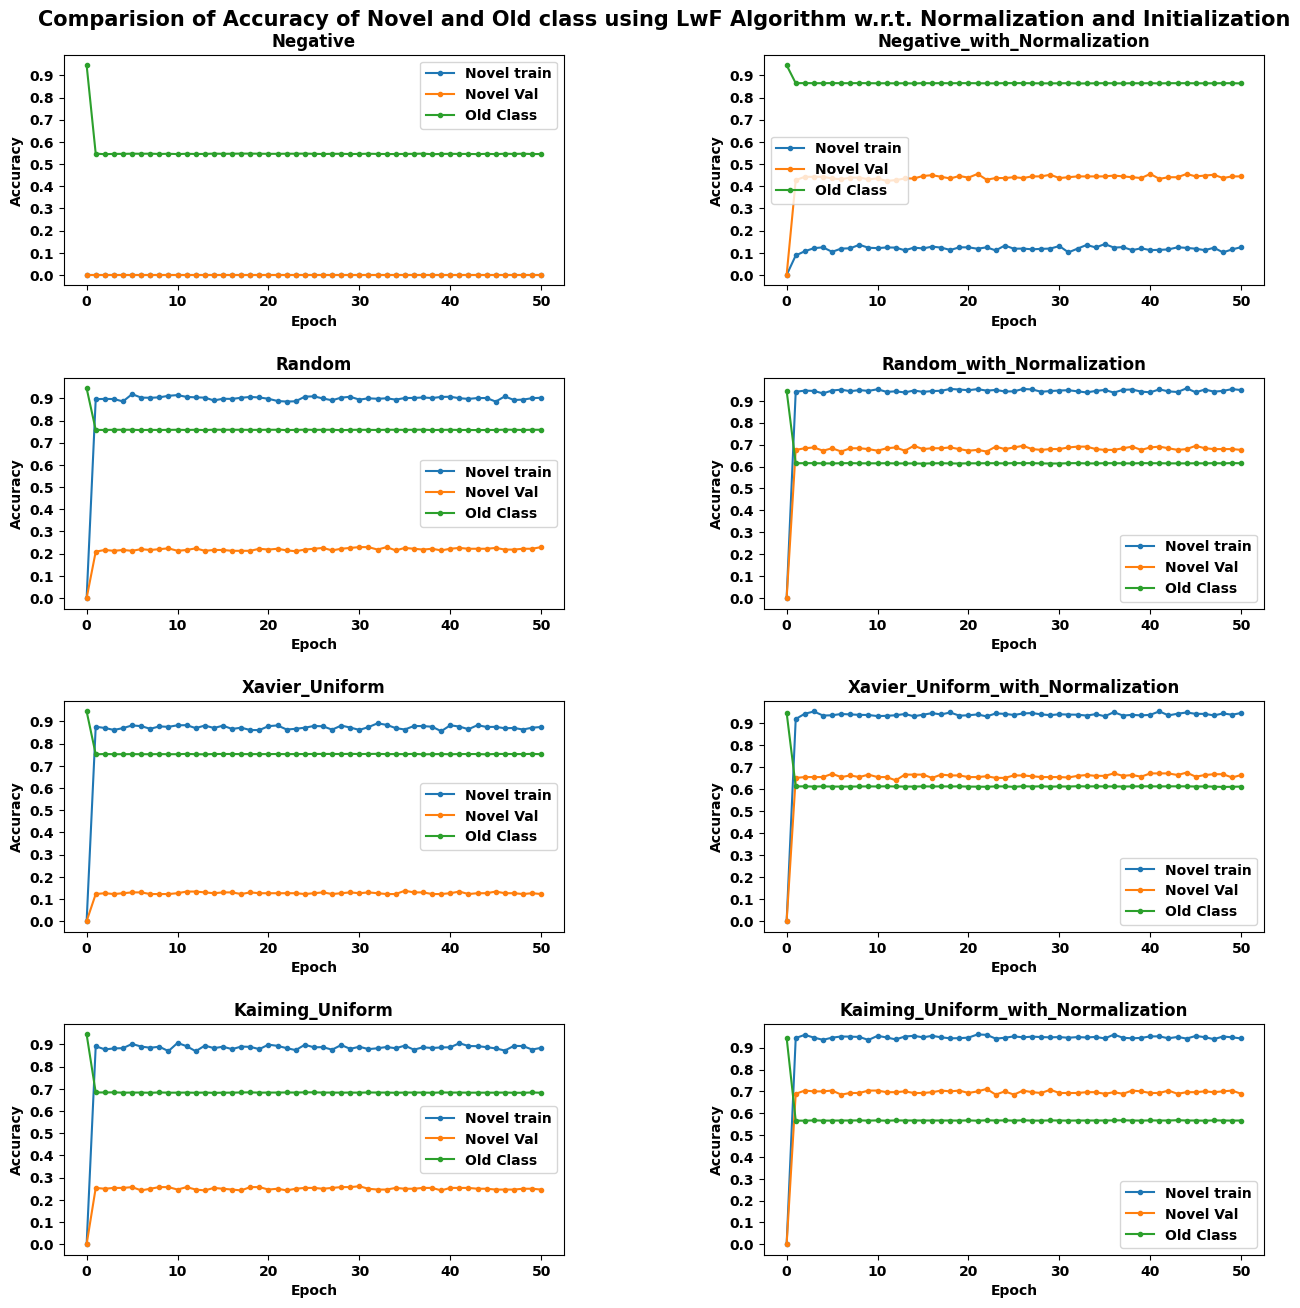

In [ ]:
plt.rcParams["figure.figsize"] = [15, 15]
plt.rc('font', weight='bold')
fig, ax = plt.subplots(4, 2)

fig.suptitle("Comparision of Accuracy of Novel and Old class using LwF Algorithm w.r.t. Normalization and Initialization",  fontsize=15, weight = 'extra bold', y=0.93)
ax[0,0].plot(df_negative[['train_accuracy']], label = 'Novel train', marker = '.')
ax[0,0].plot(df_negative[['val_accuracy']], label = 'Novel Val', marker = '.')
ax[0,0].plot(df_negative[['old_class_accuracy']], label= 'Old Class', marker = '.')
ax[0,0].legend()
ax[0,0].set_yticks(np.arange(0, 1, 0.1))
ax[0,0].set_title(init_labels['negative'], weight = 'bold')
ax[0,0].set_xlabel('Epoch', weight = 'bold')
ax[0,0].set_ylabel('Accuracy', weight = 'bold')

ax[0,1].plot(df_negative_norm[['train_accuracy']], label = 'Novel train',  marker = '.')
ax[0,1].plot(df_negative_norm[['val_accuracy']], label = 'Novel Val',  marker = '.')
ax[0,1].plot(df_negative_norm[['old_class_accuracy']], label= 'Old Class',  marker = '.')
ax[0,1].legend()
ax[0,1].set_yticks(np.arange(0, 1, 0.1))
ax[0,1].set_title(init_labels['negative_norm'], weight = 'bold')
ax[0,1].set_xlabel('Epoch', weight = 'bold')
ax[0,1].set_ylabel('Accuracy', weight = 'bold')

ax[1,0].plot(df_random[['train_accuracy']], label = 'Novel train',  marker = '.')
ax[1,0].plot(df_random[['val_accuracy']], label = 'Novel Val',  marker = '.')
ax[1,0].plot(df_random[['old_class_accuracy']], label= 'Old Class',  marker = '.')
ax[1,0].legend()
ax[1,0].set_yticks(np.arange(0, 1, 0.1))
ax[1,0].set_title(init_labels['random'], weight = 'bold')
ax[1,0].set_xlabel('Epoch', weight = 'bold')
ax[1,0].set_ylabel('Accuracy', weight = 'bold')

ax[1,1].plot(df_random_norm[['train_accuracy']], label = 'Novel train',  marker = '.')
ax[1,1].plot(df_random_norm[['val_accuracy']], label = 'Novel Val',  marker = '.')
ax[1,1].plot(df_random_norm[['old_class_accuracy']], label= 'Old Class',  marker = '.')
ax[1,1].legend()
ax[1,1].set_yticks(np.arange(0, 1, 0.1))
ax[1,1].set_title(init_labels['random_norm'], weight = 'bold')
ax[1,1].set_xlabel('Epoch', weight = 'bold')
ax[1,1].set_ylabel('Accuracy', weight = 'bold')

ax[2,0].plot(df_xavier[['train_accuracy']], label = 'Novel train',  marker = '.')
ax[2,0].plot(df_xavier[['val_accuracy']], label = 'Novel Val',  marker = '.')
ax[2,0].plot(df_xavier[['old_class_accuracy']], label= 'Old Class',  marker = '.')
ax[2,0].legend()
ax[2,0].set_yticks(np.arange(0, 1, 0.1))
ax[2,0].set_title(init_labels['xavier_uniform'], weight = 'bold')
ax[2,0].set_xlabel('Epoch', weight = 'bold')
ax[2,0].set_ylabel('Accuracy', weight = 'bold')

ax[2,1].plot(df_xavier_norm[['train_accuracy']], label = 'Novel train',  marker = '.')
ax[2,1].plot(df_xavier_norm[['val_accuracy']], label = 'Novel Val', marker = '.')
ax[2,1].plot(df_xavier_norm[['old_class_accuracy']], label= 'Old Class', marker = '.')
ax[2,1].legend()
ax[2,1].set_yticks(np.arange(0, 1, 0.1))
ax[2,1].set_title(init_labels['xavier_uniform_norm'], weight = 'bold')
ax[2,1].set_xlabel('Epoch', weight = 'bold')
ax[2,1].set_ylabel('Accuracy', weight = 'bold')

ax[3,0].plot(df_kaiming[['train_accuracy']], label = 'Novel train',  marker = '.')
ax[3,0].plot(df_kaiming[['val_accuracy']], label = 'Novel Val', marker = '.')
ax[3,0].plot(df_kaiming[['old_class_accuracy']], label= 'Old Class',  marker = '.')
ax[3,0].legend()
ax[3,0].set_yticks(np.arange(0, 1, 0.1))
ax[3,0].set_title(init_labels['kaiming_uniform'], weight = 'bold')
ax[3,0].set_xlabel('Epoch', weight = 'bold')
ax[3,0].set_ylabel('Accuracy', weight = 'bold')

ax[3,1].plot(df_kaiming_norm[['train_accuracy']], label = 'Novel train',  marker = '.')
ax[3,1].plot(df_kaiming_norm[['val_accuracy']], label = 'Novel Val',  marker = '.')
ax[3,1].plot(df_kaiming_norm[['old_class_accuracy']], label= 'Old Class',  marker = '.')
ax[3,1].legend()
ax[3,1].set_yticks(np.arange(0, 1, 0.1))
ax[3,1].set_title(init_labels['kaiming_uniform_norm'], weight = 'bold')
ax[3,1].set_xlabel('Epoch', weight = 'bold')
ax[3,1].set_ylabel('Accuracy', weight = 'bold')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

fig.savefig("acc_comparision_lwf.png", format="png", dpi=600, bbox_inches="tight")
fig.savefig("acc_comparision_lwf.eps", format="eps", dpi=1200, bbox_inches="tight", transparent=True)
fig.savefig("acc_comparision_lwf.pdf", format="pdf", dpi=1200, bbox_inches="tight", transparent=True)

Comparision of Old accuracy for LwF w.r.t initialization and Normalization

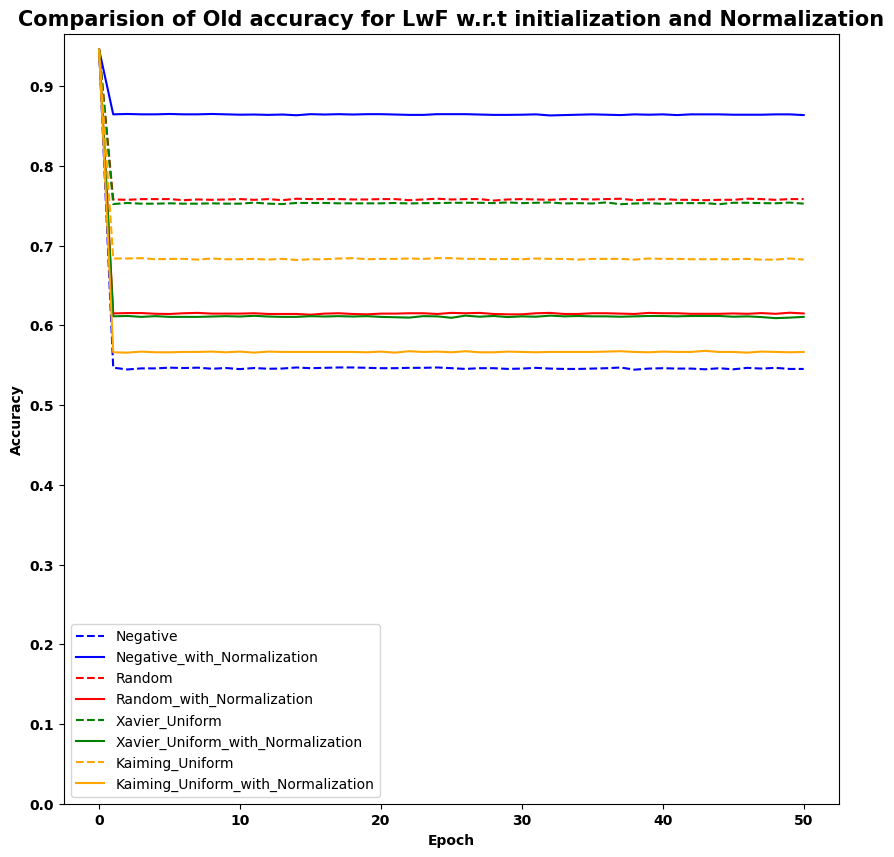

In [ ]:
plt.rcParams["figure.figsize"] = [10, 10]
fig = plt.figure(figsize = (10,10))

plt.plot(df_negative[['old_class_accuracy']], label = init_labels['negative'], linestyle = '--', color = 'b')
plt.plot(df_negative_norm[['old_class_accuracy']], label = init_labels['negative_norm'], linestyle = '-', color = 'b')
plt.plot(df_random[['old_class_accuracy']], label = init_labels['random'], linestyle = '--', color = 'r')
plt.plot(df_random_norm[['old_class_accuracy']], label = init_labels['random_norm'], linestyle = '-', color = 'r')
plt.plot(df_xavier[['old_class_accuracy']], label = init_labels['xavier_uniform'], linestyle = '--', color = 'g')
plt.plot(df_xavier_norm[['old_class_accuracy']], label = init_labels['xavier_uniform_norm'], linestyle = '-', color = 'g')
plt.plot(df_kaiming[['old_class_accuracy']], label = init_labels['kaiming_uniform'], linestyle = '--', color = 'orange')
plt.plot(df_kaiming_norm[['old_class_accuracy']], label = init_labels['kaiming_uniform_norm'], linestyle = '-', color = 'orange')
plt.yticks(np.arange(0,1,0.1), weight = 'bold')
plt.xticks(np.arange(0,51,10), weight = 'bold')
plt.xlabel('Epoch', weight = 'bold')
plt.ylabel('Accuracy', weight = 'bold')
plt.title('Comparision of Old accuracy for LwF w.r.t initialization and Normalization', fontsize=15, weight = 'extra bold')
plt.legend()
fig.savefig("old_class_acc_lwf.png", format="png", dpi=600, bbox_inches="tight")
fig.savefig("old_class_acc_lwf.eps", format="eps", dpi=1200, bbox_inches="tight", transparent=True)
fig.savefig("old_class_acc_lwf.pdf", format="pdf", dpi=1200, bbox_inches="tight", transparent=True)

Comparision of Novel class accuracy for LwF w.r.t initialization and Normalization

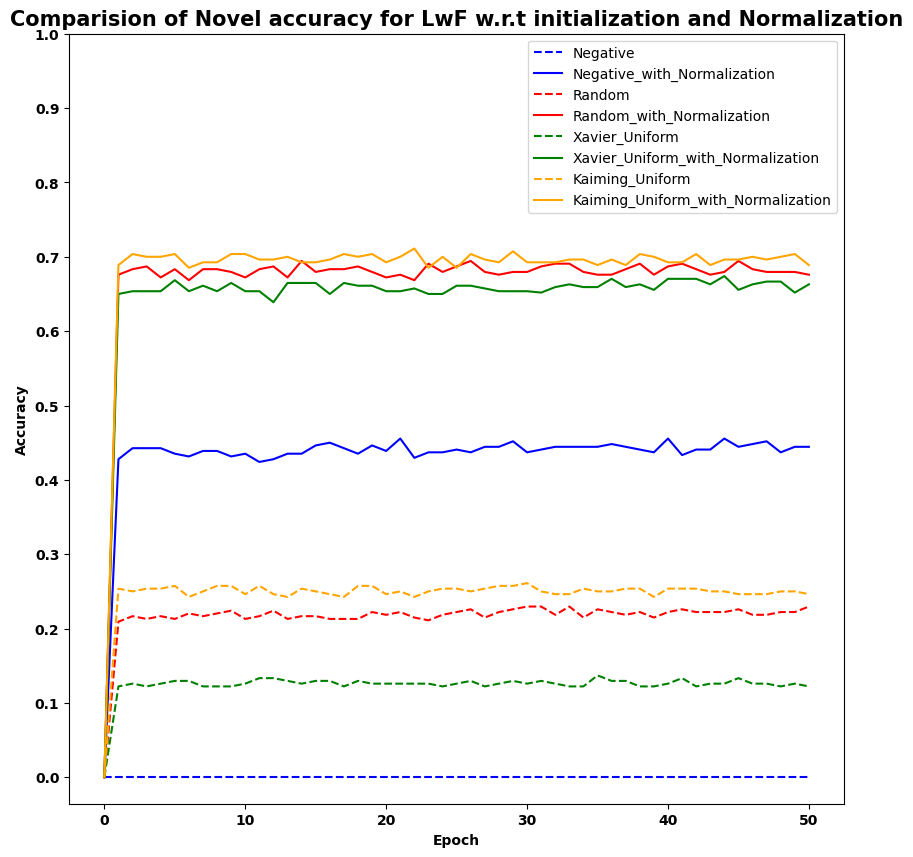

In [ ]:
plt.rcParams["figure.figsize"] = [10, 10]
fig = plt.figure(figsize = (10,10))

plt.plot(df_negative[['val_accuracy']], label = init_labels['negative'], linestyle = '--', color = 'b')
plt.plot(df_negative_norm[['val_accuracy']], label = init_labels['negative_norm'], linestyle = '-', color = 'b')
plt.plot(df_random[['val_accuracy']], label = init_labels['random'], linestyle = '--', color = 'r')
plt.plot(df_random_norm[['val_accuracy']], label = init_labels['random_norm'], linestyle = '-', color = 'r')
plt.plot(df_xavier[['val_accuracy']], label = init_labels['xavier_uniform'], linestyle = '--', color = 'g')
plt.plot(df_xavier_norm[['val_accuracy']], label = init_labels['xavier_uniform_norm'], linestyle = '-', color = 'g')
plt.plot(df_kaiming[['val_accuracy']], label = init_labels['kaiming_uniform'], linestyle = '--', color = 'orange')
plt.plot(df_kaiming_norm[['val_accuracy']], label = init_labels['kaiming_uniform_norm'], linestyle = '-', color = 'orange')
plt.yticks(np.arange(0,1.1,0.1), weight = 'bold')
plt.xticks(np.arange(0,51,10), weight = 'bold')
plt.xlabel('Epoch', weight = 'bold')
plt.ylabel('Accuracy', weight = 'bold')
plt.title('Comparision of Novel accuracy for LwF w.r.t initialization and Normalization', fontsize=15, weight = 'extra bold')
plt.legend()
fig.savefig("novel_acc_lwf.png", format="png", dpi=600, bbox_inches="tight")
fig.savefig("novel_acc_lwf.eps", format="eps", dpi=1200, bbox_inches="tight", transparent=True)
fig.savefig("novel_acc_lwf.pdf", format="pdf", dpi=1200, bbox_inches="tight", transparent=True)

# LwF with new layer expansion in network

In this section we try to add extra layer before last linear layer in order to solve initial accuracy drop problem.

Here we can see that addition of extra layer before last linear layer doensn't give good results for the old classes. Also Novel classes results are not improved. Addition of extra layer is not a good solution for LwF initial drop.

In [ ]:
class VGGNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # self.dropout = nn.Dropout(0.25)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(128 * 3 * 3, 128 * 3 * 3)
        self.linear = nn.Linear(128 * 3 * 3, out_features=11)

    def forward(self, input_data):
        x = self.conv1(input_data)
        # x= self.dropout(x)
        x = self.conv2(x)
        # x= self.dropout(x)
        x = self.conv3(x)
        # x= self.dropout(x)
        x = self.conv4(x)
        # x = self.dropout(x)
        x = self.flatten(x)
        x = self.linear1(x)
        logits = self.linear(x)
        return logits

In [ ]:
learning_rate = 0.00001
T = 2
alpha = 1
weight_decay = 1e-6
num_epochs = 50
log = []
_network = 'vgg'

# #Model 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load model
print("Loading the pre-trained model...")
model = get_convnet("vgg")

#save old accuracy before increment
old_class_accuracy, old_class_loss = calculate_accuracy(dataloader=old_test_dataloader, model=model)
log.append({
  'epoch': -1,
  'train_loss': np.nan,
  'train_accuracy': 0,
  'val_loss': np.nan,
  'val_accuracy': 0,
  'old_class_loss' : old_class_loss,
  'old_class_accuracy': old_class_accuracy
  })
#save prev model before increment
prev_model = copy.deepcopy(model)
#freeze previous model
for param in prev_model.parameters():
  param.requires_grad = False

# Add weights at the last linear layer for novel class 
# model = _incremental_model(model, init_labels['random'], is_normalize = False)
# model = _incremental_model(model, init_labels['negative'], is_normalize = True)
# model = _incremental_model(model, init_labels['xavier_uniform'], is_normalize = True)
model = _incremental_model(model, init_labels['kaiming_uniform'], is_normalize = True)
_in_features = model.linear.in_features
model.linear1 = nn.Linear(in_features=_in_features, out_features=_in_features)

#after increment last layer we will add one more layer before last linear layer
#this will copy all weights from model to new model_exp so we can use updated forward method
model_exp = VGGNet()
model_exp.load_state_dict(copy.deepcopy(model.state_dict())) 

optimizer = torch.optim.SGD(model_exp.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,30,50,70,80], gamma=0.1)

Loading the pre-trained model...
getting VGG pre-trained model
Initialization: Kaiming_Uniform
with L2 normalization


In [ ]:
model_exp

VGGNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=1152, out_features=1152, bias=True)
  (linear): Linear(in_features=1152, out_features=11, bias=True)
)

In [ ]:
train(novel_train_dataloader, 
      novel_test_dataloader, 
      old_test_dataloader, 
      optimizer,
      scheduler, 
      model_exp, 
      prev_model, 
      num_epochs, 
      alpha, 
      T, 
      log)

Epoch [0]... train_loss: 4.253947882712642, train_acc: 0.47561625582944705
	     val_loss: 2.2654478549957275, val_acc: 0.5092592592592593
	     old_loss: 6.05670166015625, old_acc: 0.03737864077669903
Epoch [1]... train_loss: 3.948900566825384, train_acc: 0.49960026648900735
	     val_loss: 1.6128824949264526, val_acc: 0.524074074074074
	     old_loss: 6.220834255218506, old_acc: 0.03737864077669903
Epoch [2]... train_loss: 3.94852713089955, train_acc: 0.4998334443704197
	     val_loss: 1.7429662942886353, val_acc: 0.5166666666666667
	     old_loss: 7.025356769561768, old_acc: 0.03737864077669903
Epoch [3]... train_loss: 3.948214621483525, train_acc: 0.49976682211858764
	     val_loss: 1.5437898635864258, val_acc: 0.512962962962963
	     old_loss: 5.509570598602295, old_acc: 0.03737864077669903
Epoch [4]... train_loss: 3.9486340208898616, train_acc: 0.49960026648900735
	     val_loss: 1.1920527219772339, val_acc: 0.5277777777777778
	     old_loss: 6.802502632141113, old_acc: 0.0373786

In [ ]:
df_logs = pd.DataFrame(log)

Text(0.5, 1.0, 'Accuracy comaparision for LwF with additional linear layer')

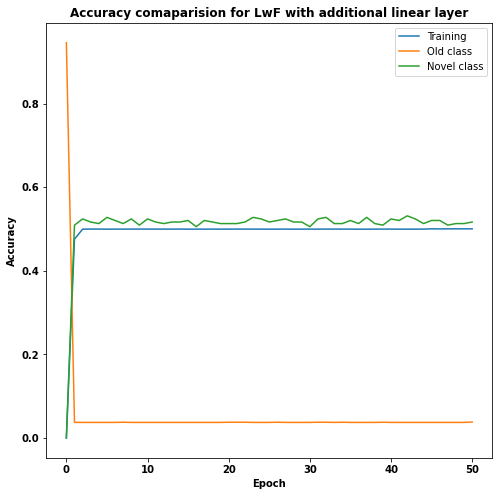

In [ ]:
plt.rcParams["figure.figsize"] = [8, 8]
plt.plot(df_logs[['train_accuracy']], label = 'Training')
plt.plot(df_logs[['old_class_accuracy']], label = 'Old class')
plt.plot(df_logs[['val_accuracy']], label = 'Novel class')
plt.legend()
plt.xlabel('Epoch', weight = 'bold')
plt.ylabel('Accuracy', weight = 'bold')
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')
plt.title("Accuracy comaparision for LwF with additional linear layer", weight = 'bold')

# Multiclass Continuous Learning

In this section, we analyse old accuracy performance while learning 5 tasks one by one. and save results to use in next section. 


In [ ]:
learning_rate = 0.000001
T = 2
alpha = 1
weight_decay = 1e-2
num_epochs = 3
log = []
_network = 'vgg'

# #Model 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load model
print("Loading the pre-trained model...")
model = get_convnet("vgg")

#save old accuracy before increment
old_class_accuracy, old_class_loss = calculate_accuracy(dataloader=old_test_dataloader, model=model)
log.append({
  'epoch': -1,
  'train_loss': np.nan,
  'train_accuracy': 0,
  'val_loss': np.nan,
  'val_accuracy': 0,
  'old_class_loss' : old_class_loss,
  'old_class_accuracy': old_class_accuracy
  })

Loading the pre-trained model...
getting VGG pre-trained model


In [ ]:
multiclass_learning = ["follow", "marvin", "visual", "house", "happy"]
digits = ['zero','one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'] 
new_targets_list = digits

_temp = digits + multiclass_learning
#save prev model before increment
prev_model = copy.deepcopy(model)
#freeze previous model
for param in prev_model.parameters():
  param.requires_grad = False

#increse last nodes in multiclass
# model = _incremental_model(model, is_normalize = True, _no_out_features = 15, _no_novel_class=len(multiclass_learning))
model = _incremental_model(model, init_method=init_labels['xavier_uniform'], is_normalize = True, _no_out_features = 15, _no_novel_class=len(multiclass_learning))

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200], gamma=0.1) #dont want scheduler here

#for loop to learn novel tasks one by one and record old tasks performance during training.
for _class_name in multiclass_learning:
  print(f"Training for {_class_name}")
  traindata = SubsetSC("training", "novel", novel_class_list= [_class_name], dataset_length=50)
  testdata = SubsetSC("testing", "novel", novel_class_list= [_class_name], dataset_length=20)
  new_targets_list += [_class_name]
  def collate_fn(batch):
          tensors, targets = [], []
          for waveform, label in batch:
                  tensors += [torch.squeeze(waveform)]
                  targets += [label_to_index(_temp, label)]
          tensors = torch.unsqueeze(pad_sequence(tensors), 1)
          targets = torch.stack(targets)
          return tensors, targets
  new_novel_train_dataloader = DataLoader(traindata,batch_size=10, collate_fn=collate_fn, shuffle=True)
  new_novel_test_dataloader = DataLoader(testdata, batch_size = 2, collate_fn=collate_fn, shuffle=True)

  train(new_novel_train_dataloader, 
        new_novel_test_dataloader, 
        old_test_dataloader, 
        optimizer,
        scheduler, 
        model,
        prev_model,
        num_epochs,  
        alpha, 
        T, 
        log, 
        _novel_class_len = len(multiclass_learning),
        show_new = False)


Initialization: Xavier_Uniform
with L2 normalization
Training for follow
Epoch [0]... train_loss: 4.7381336212158205, train_acc: 0.48
	     val_loss: 1.7204601764678955, val_acc: 0.4
	     old_loss: 1.2545174360275269, old_acc: 0.44518030513176143
Epoch [1]... train_loss: 5.017395496368408, train_acc: 0.4
	     val_loss: 1.5495831966400146, val_acc: 0.5
	     old_loss: 2.2599875926971436, old_acc: 0.4377600554785021
Epoch [2]... train_loss: 4.471875190734863, train_acc: 0.52
	     val_loss: 1.7690925598144531, val_acc: 0.6
	     old_loss: 1.6341708898544312, old_acc: 0.4265950069348128
Training for marvin
Epoch [0]... train_loss: 5.607400131225586, train_acc: 0.14
	     val_loss: 3.0636651515960693, val_acc: 0.05
	     old_loss: 2.4443516731262207, old_acc: 0.42004160887656034
Epoch [1]... train_loss: 5.701496505737305, train_acc: 0.18
	     val_loss: 2.7743113040924072, val_acc: 0.1
	     old_loss: 1.6284143924713135, old_acc: 0.41955617198335643
Epoch [2]... train_loss: 5.97468957901

In [ ]:
df_multiclass_logs = pd.DataFrame(log)

In [ ]:
filename = str(datetime.now().date()) + '_' + str(datetime.now().time()).replace(':', '.')
# path = "results_lwof_multiclass_single_head" + str(init_labels['random_norm']) + '_' + filename
# path = "results_lwof_multiclass_single_head" + str(init_labels['random']) + '_' + filename
# path = "results_lwof_multiclass_single_head" + str(init_labels['negative']) + '_' + filename
# path = "results_lwof_multiclass_single_head" + str(init_labels['negative_norm']) + '_' + filename
# path = "results_lwof_multiclass_single_head" + str(init_labels['xavier_uniform']) + '_' + filename
path = "results_lwof_multiclass_single_head" + str(init_labels['xavier_uniform_norm']) + '_' + filename
# path = "results_lwof_multiclass_single_head" + str(init_labels['kaiming_uniform']) + '_' + filename
# path = "results_lwof_multiclass_single_head" + str(init_labels['kaiming_uniform_norm']) + '_' + filename

df_multiclass_logs.to_pickle(path)
print(f"Saved training data to file {path}")

Saved training data to file results_lwof_multiclass_single_headXavier_Uniform_with_Normalization_2022-11-29_11.31.17.090686


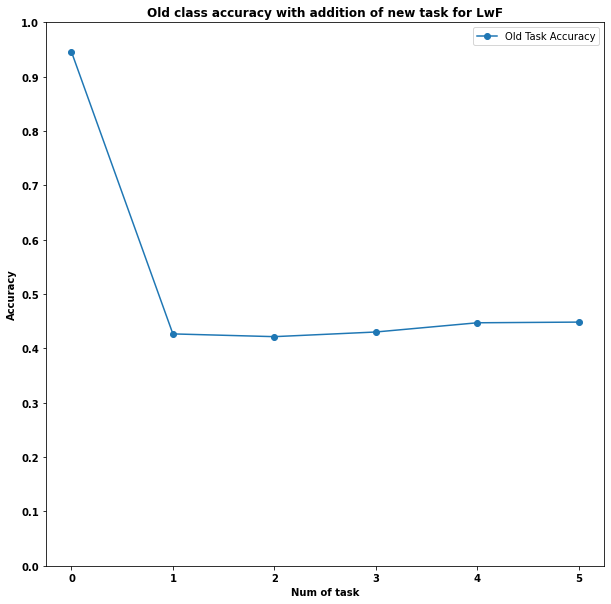

In [ ]:
fig = plt.figure()
old_class_acc = df_multiclass_logs[['old_class_accuracy']][::num_epochs]
task_number = np.arange(len(old_class_acc))
plt.plot(task_number,old_class_acc, label= "Old Task Accuracy", marker = 'o')
plt.xlabel("Num of task", weight = 'bold')
plt.ylabel("Accuracy", weight = 'bold')
plt.xticks(weight='bold')
plt.yticks(np.arange(0,1.1,0.1),weight='bold')
plt.title("Old class accuracy with addition of new task for LwF", weight = 'bold')
plt.legend()
fig.savefig("Lwf_baseline_comparision.png", format="png", dpi=600, bbox_inches="tight")
fig.savefig("Lwf_baseline_comparision.eps", format="eps", dpi=1200, bbox_inches="tight", transparent=True)
fig.savefig("Lwf_baseline_comparision.pdf", format="pdf", dpi=1200, bbox_inches="tight", transparent=True)


Code for random init method

In [29]:
learning_rate = 0.0000001
T = 4
alpha = 2
weight_decay = 1e-2
num_epochs = 2
log = []
_network = 'vgg'

# #Model 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load model
print("Loading the pre-trained model...")
model = get_convnet("vgg")

#save old accuracy before increment
old_class_accuracy, old_class_loss = calculate_accuracy(dataloader=old_test_dataloader, model=model)
log.append({
  'epoch': -1,
  'train_loss': np.nan,
  'train_accuracy': 0,
  'val_loss': np.nan,
  'val_accuracy': 0,
  'old_class_loss' : old_class_loss,
  'old_class_accuracy': old_class_accuracy
  })

Loading the pre-trained model...
getting VGG pre-trained model


In [30]:
multiclass_learning = ["follow", "marvin", "visual", "house", "happy"]
digits = ['zero','one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'] 
new_targets_list = digits

_temp = digits + multiclass_learning
#save prev model before increment
prev_model = copy.deepcopy(model)
#freeze previous model
for param in prev_model.parameters():
  param.requires_grad = False

#increse last nodes in multiclass
# model = _incremental_model(model, is_normalize = True, _no_out_features = 15, _no_novel_class=len(multiclass_learning))
model = _incremental_model(model, init_method=init_labels['random'], is_normalize = True, _no_out_features = 15, _no_novel_class=len(multiclass_learning))

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200], gamma=0.1) #dont want scheduler here

#for loop to learn novel tasks one by one and record old tasks performance during training.
for _class_name in multiclass_learning:
  print(f"Training for {_class_name}")
  traindata = SubsetSC("training", "novel", novel_class_list= [_class_name], dataset_length=20)
  testdata = SubsetSC("testing", "novel", novel_class_list= [_class_name], dataset_length=5)
  new_targets_list += [_class_name]
  def collate_fn(batch):
          tensors, targets = [], []
          for waveform, label in batch:
                  tensors += [torch.squeeze(waveform)]
                  targets += [label_to_index(_temp, label)]
          tensors = torch.unsqueeze(pad_sequence(tensors), 1)
          targets = torch.stack(targets)
          return tensors, targets
  new_novel_train_dataloader = DataLoader(traindata,batch_size=10, collate_fn=collate_fn, shuffle=True)
  new_novel_test_dataloader = DataLoader(testdata, batch_size =5, collate_fn=collate_fn, shuffle=True)

  train(new_novel_train_dataloader, 
        new_novel_test_dataloader, 
        old_test_dataloader, 
        optimizer,
        scheduler, 
        model,
        prev_model,
        num_epochs,  
        alpha, 
        T, 
        log, 
        _novel_class_len = len(multiclass_learning),
        show_new = True)


with L2 normalization
Training for follow
Epoch [0]... train_loss: 5.939178466796875, train_acc: 0.30000000000000004
	     val_loss: 2.346329689025879, val_acc: 0.0
	     old_loss: 1.3546603918075562, old_acc: 0.6185852981969486
Epoch [1]... train_loss: 6.500416994094849, train_acc: 0.3
	     val_loss: 2.3378405570983887, val_acc: 0.0
	     old_loss: 0.7143010497093201, old_acc: 0.6201803051317615
Training for marvin
Epoch [0]... train_loss: 6.569320440292358, train_acc: 0.15000000000000002
	     val_loss: 2.3188939094543457, val_acc: 0.0
	     old_loss: 0.5146779417991638, old_acc: 0.6199375866851595
Epoch [1]... train_loss: 6.479255676269531, train_acc: 0.05
	     val_loss: 2.318307638168335, val_acc: 0.0
	     old_loss: 1.2232201099395752, old_acc: 0.6192787794729542
Training for visual
Epoch [0]... train_loss: 8.089066982269287, train_acc: 0.15000000000000002
	     val_loss: 3.807849407196045, val_acc: 0.2
	     old_loss: 1.4958127737045288, old_acc: 0.6195214979195561
Epoch [1]...

In [31]:
df_multiclass_logs = pd.DataFrame(log)

In [32]:
filename = str(datetime.now().date()) + '_' + str(datetime.now().time()).replace(':', '.')
path = "results_lwof_multiclass_single_head" + str(init_labels['random']) + '_' + filename

df_multiclass_logs.to_pickle(path)
print(f"Saved training data to file {path}")

Saved training data to file results_lwof_multiclass_single_headRandom_2022-12-19_19.25.13.161972


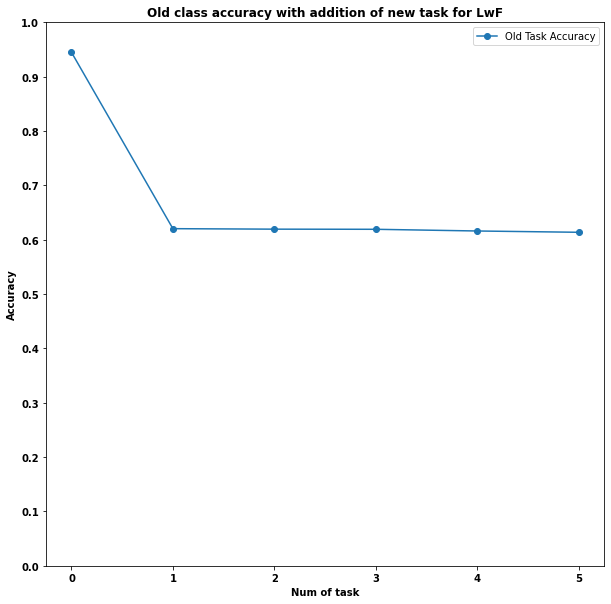

In [33]:
fig = plt.figure()
old_class_acc = df_multiclass_logs[['old_class_accuracy']][::num_epochs]
task_number = np.arange(len(old_class_acc))
plt.plot(task_number,old_class_acc, label= "Old Task Accuracy", marker = 'o')
plt.xlabel("Num of task", weight = 'bold')
plt.ylabel("Accuracy", weight = 'bold')
plt.xticks(weight='bold')
plt.yticks(np.arange(0,1.1,0.1),weight='bold')
plt.title("Old class accuracy with addition of new task for LwF", weight = 'bold')
plt.legend()
# fig.savefig("Lwf_baseline_comparision.png", format="png", dpi=600, bbox_inches="tight")
# fig.savefig("Lwf_baseline_comparision.eps", format="eps", dpi=1200, bbox_inches="tight", transparent=True)
# fig.savefig("Lwf_baseline_comparision.pdf", format="pdf", dpi=1200, bbox_inches="tight", transparent=True)


# LwF algorithm comparision with retraining baseline


In this section, the old accuracy performance of the LwF algorithm is compared with that of the retrained baseline method in order to assess the effectiveness of the catastrophic forgetting effect. After each of the five tasks has been trained for a few epochs on the pre-trained network,  the old class accuracy is recorded. For this experiment, the Xavier Uniform initialization method is used with normalization   because it works better for both old and novel classes. As seen in Plot, the retraining baseline significantly reduces the old class accuracy. However, LwF algorithm maintains the performance of the old class while learning all novel tasks after an initial drop in accuracy. 

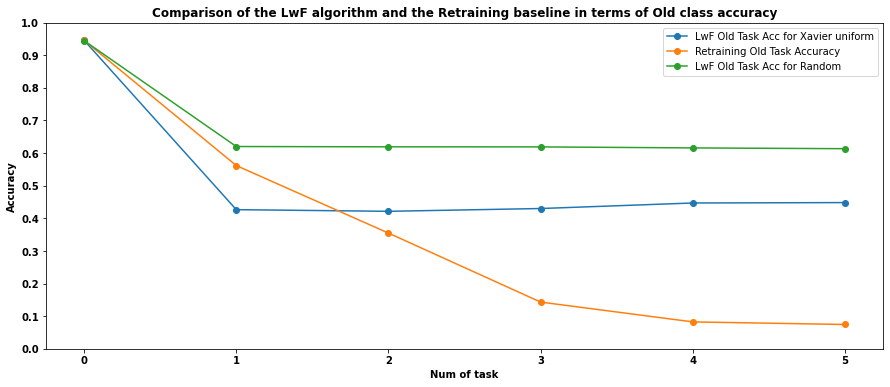

In [37]:
#take above saved result pickle files for lwf and 
#take saved result file for retraining baselin(From https://github.com/PriyankaTUI/AudioClassificationWithDeepLearningAnalysis/tree/master/results)

_lwf_result = pd.read_pickle("results/lwof/results_lwof_multiclass_single_headXavier_Uniform_with_Normalization_2022-11-29_11.31.17.090686")
_retraining_baseline_result = pd.read_pickle("results/retrain/retraining_baseline.pkl")
_lwf_results_random = df_multiclass_logs

fig = plt.figure(figsize = (15,6))
lwf_old_class_acc = _lwf_result[['old_class_accuracy']][::3]
_lwf_old_class_acc_random = _lwf_results_random[['old_class_accuracy']][::2]
retraining_baseline_old_class_acc = _retraining_baseline_result[['old_class_accuracy']][::3]
task_number = np.arange(len(lwf_old_class_acc))
plt.plot(task_number,lwf_old_class_acc, label= "LwF Old Task Acc for Xavier uniform", marker = 'o')
plt.plot(task_number,retraining_baseline_old_class_acc, label= "Retraining Old Task Accuracy", marker = 'o')
plt.plot(task_number,_lwf_old_class_acc_random, label= "LwF Old Task Acc for Random", marker = 'o')
plt.xlabel("Num of task", weight = 'bold')
plt.ylabel("Accuracy", weight = 'bold')
plt.xticks(weight='bold')
plt.yticks(np.arange(0,1.1,0.1),weight='bold')
plt.title("Comparison of the LwF algorithm and the Retraining baseline in terms of Old class accuracy", weight = 'bold')
plt.legend()
fig.savefig("Lwf_retraining_comparision.png", format="png", dpi=600, bbox_inches="tight")
fig.savefig("Lwf_retraining_comparision.eps", format="eps", dpi=1200, bbox_inches="tight", transparent=True)
fig.savefig("Lwf_retrining_comparision.pdf", format="pdf", dpi=1200, bbox_inches="tight", transparent=True)
